### Azhar Abdurrasyid
### 13517097

In [1]:
import pandas as pd

training_data = pd.read_csv('training_data.csv')
testing_data = pd.read_csv('testing_data.csv')
val_data = pd.read_csv('val_data.csv')

print("TRAINING DATA")
print(training_data.shape)
print(training_data.head())
print("\n")

print("TESTING DATA")
print(testing_data.shape) 
print(testing_data.head())
print("\n")

print("VALIDATION DATA")
print(val_data.shape)
print(val_data.head())

TRAINING DATA
(4502, 2)
  type                                               text
0  ham             Babe, I'm back ... Come back to me ...
1  ham                         S:)no competition for him.
2  ham    Yup having my lunch buffet now.. U eat already?
3  ham  Storming msg: Wen u lift d phne, u say HELLO D...
4  ham  Mark works tomorrow. He gets out at 5. His wor...


TESTING DATA
(556, 2)
  type                                               text
0  ham                        Anything lor... U decide...
1  ham  So u pay first lar... Then when is da stock co...
2  ham  I got a call from a landline number. . . I am ...
3  ham  Cool. So how come you havent been wined and di...
4  ham  Dunno lei u all decide lor. How abt leona? Oop...


VALIDATION DATA
(501, 2)
  type                                               text
0  ham                       We can make a baby in yo tho
1  ham          Aight will do, thanks again for comin out
2  ham  hope things went well at 'doctors' ;) reminds .

## Data Preparation

In [23]:
# Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Spell correction
from textblob import TextBlob

# Lemmatizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

# Tokenizer
from nltk import word_tokenize

def prepare_data(raw_data):
    cleaned_data = raw_data

    # Remove non-alphanumeric
    cleaned_data = cleaned_data.str.replace('[^\s\w]|_', '')
    
    # Transform to lowercase
    cleaned_data = cleaned_data.str.lower()
    
    # Remove stop words
    cleaned_data = cleaned_data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Spell correction (exhaustive)
    cleaned_data = cleaned_data.apply(lambda sentence: str(TextBlob(sentence).correct()))
    
    # Tokenize & Lemmatize
    tokenized_cleaned_data = []
    for sentence in cleaned_data:
        tokenized_cleaned_data.append([lemmatizer.lemmatize(w) for w in word_tokenize(sentence)])

    return tokenized_cleaned_data
    

In [24]:
training_data['tokenize'] = prepare_data(training_data['text'])

testing_data['tokenize'] = prepare_data(testing_data['text'])

val_data['tokenize'] = prepare_data(val_data['text'])

print("TRAINING DATA")
print(training_data.shape)
print(training_data.head())
print("\n")

print("TESTING DATA")
print(testing_data.shape)
print(testing_data.head())
print("\n")

print("VALIDATION DATA")
print(val_data.shape)
print(val_data.head())

TRAINING DATA
(4502, 3)
  type                                               text  \
0  ham             Babe, I'm back ... Come back to me ...   
1  ham                         S:)no competition for him.   
2  ham    Yup having my lunch buffet now.. U eat already?   
3  ham  Storming msg: Wen u lift d phne, u say HELLO D...   
4  ham  Mark works tomorrow. He gets out at 5. His wor...   

                                            tokenize  
0                       [babe, in, back, come, back]  
1                                  [so, competition]  
2               [up, lunch, buffet, u, eat, already]  
3  [storming, mug, wen, u, lift, pine, u, say, he...  
4  [mark, work, tomorrow, get, 5, work, house, me...  


TESTING DATA
(556, 3)
  type                                               text  \
0  ham                        Anything lor... U decide...   
1  ham  So u pay first lar... Then when is da stock co...   
2  ham  I got a call from a landline number. . . I am ...   
3  ham  Coo

### Feature Extraction

#### Features as bag of words<br>
1. Create word dictionaries from training data <br>
2. Transform sentence to Term x Document matrix

In [43]:
# Create word dictionaries
def get_word_dictionaries(data):
    word_dictionaries = []
    for sentence in data:
        for word in sentence:
            word_dictionaries.append(word)
            
    return list(set(word_dictionaries))

# Transform sentence to Term x Document matrix
def get_word_counts(data, dictionaries):
    word_counts_per_term = {unique_word: [0] * len(data) for unique_word in dictionaries}
    
    for index, sentence in enumerate(data):
        for word in sentence:
            if word in dictionaries:
                word_counts_per_term[word][index] += 1
            
    return pd.DataFrame(word_counts_per_term)  

In [36]:
dictionaries = get_word_dictionaries(training_data['tokenize'])
word_counts['traning_data'] = get_word_counts(training_data['tokenize'], dictionaries)

training_data_clean = pd.concat([training_data['type'], word_counts['training_data']], axis=1)
training_data_clean.head()

,type,ba,squatting,executive,feather,endowed,woolen,aeronautics,listening2the,science,...,weed,satisfy,ali,ranjith,vive,concentrate,banneduk,mobilesvary,throwing,chikkuwat
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
word_counts_train = get_word_counts(training_data['tokenize'], dictionaries)
word_counts_test = get_word_counts(testing_data['tokenize'], dictionaries)
word_counts_val = get_word_counts(val_data['tokenize'], dictionaries)

### Classification

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

# Get Accuracy
def get_accuracy(actual, pred):
    count = 0
    for i in range(len(actual)):
        if actual[i] == pred[i]:
            count += 1
    return count/len(actual)

class_names = ['ham', 'spam']
# Display confusion matrix
def confusion_matrix(classifier, x, y, title):
    disp = plot_confusion_matrix(classifier, x, y, display_labels=class_names, cmap=plt.cm.Blues,normalize='true')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.show()

#### Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB

batch = 10
best_acc = 0
best_c = 0

for i in range (batch):
    c_temp = 5e-10 + (i*5e-10)
    nb = GaussianNB(var_smoothing=c_temp)
    nb.fit(word_counts_train, training_data['type'])
    y_pred_nb = nb.predict(word_counts_val)
    acc = get_accuracy(val_data['type'], y_pred_nb)
    if (acc > best_acc):
        best_acc = acc
        best_c = c_temp
        
print("Chosen parameter: ", best_c)
nb = GaussianNB(var_smoothing=best_c)
nb.fit(word_counts_train, training_data['type'])
y_pred_nb = nb.predict(word_counts_test)

Chosen parameter:  5e-10


F1 Score:  0.907469342251951


Accuracy:  0.8507194244604317


Confusion Matrix NB Gaussian
[[0.84090909 0.15909091]
 [0.08333333 0.91666667]]


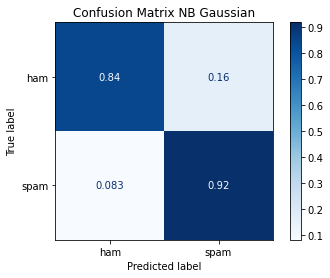

In [96]:
f1_nb = f1_score(testing_data['type'], y_pred_nb, average=None)
print("F1 Score: ", f1_nb[0])
print("\n")

accuracy = get_accuracy(testing_data['type'], y_pred_nb)
print("Accuracy: ", accuracy)
print("\n")

confusion_matrix(nb, word_counts_test, testing_data['type'], "Confusion Matrix NB Gaussian")

#### Linear SVM

In [93]:
from sklearn.svm import SVC

batch = 10
best_acc = 0
best_c = 0

for i in range (batch):
    c_temp = 0.025 + (i*0.025)
    svm = SVC(kernel="linear", C=c_temp)
    svm.fit(word_counts_train, training_data['type'])
    y_pred_svm = svm.predict(word_counts_val)
    acc = get_accuracy(val_data['type'], y_pred_svm)
    if (acc > best_acc):
        best_acc = acc
        best_c = c_temp
        
print("Chosen parameter: ", best_c)
svm = SVC(kernel="linear", C=best_c)
svm.fit(word_counts_train, training_data['type'])
y_pred_svm = svm.predict(word_counts_test)

Chosen parameter:  0.17500000000000002


F1 Score:  0.9938398357289528


Accuracy:  0.9892086330935251


Confusion Matrix SVM
[[1.         0.        ]
 [0.08333333 0.91666667]]


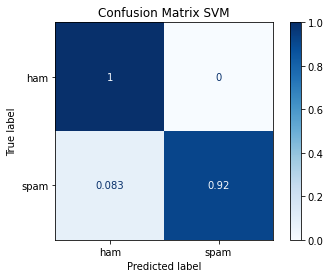

In [95]:
from sklearn.metrics import f1_score
f1_svm = f1_score(testing_data['type'], y_pred_svm, average=None)
print("F1 Score: ", f1_svm[0])
print("\n")

accuracy = get_accuracy(testing_data['type'], y_pred_svm)
print("Accuracy: ", accuracy)
print("\n")

confusion_matrix(svm, word_counts_test, testing_data['type'], "Confusion Matrix SVM")

#### Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

batch = 10
best_acc = 0
best_c = 0

for i in range (batch):
    c_temp = 0.025 + (i*0.025)
    lr = LogisticRegression(C=c_temp)
    lr.fit(word_counts_train, training_data['type'])
    y_pred_lr = lr.predict(word_counts_val)
    acc = get_accuracy(val_data['type'], y_pred_lr)
    if (acc > best_acc):
        best_acc = acc
        best_c = c_temp

print("Chosen parameter: ", best_c)
lr = LogisticRegression(C=best_c)
lr.fit(word_counts_train, training_data['type'])
y_pred_lr = lr.predict(word_counts_test)

Chosen parameter:  0.2


F1 Score:  0.9928205128205128


Accuracy:  0.9838129496402878


Confusion Matrix Logistic Regression
[[1.    0.   ]
 [0.125 0.875]]


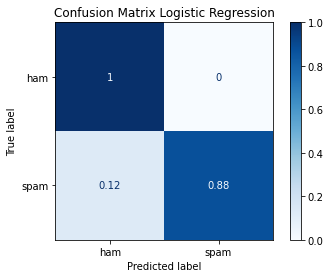

In [94]:
from sklearn.metrics import f1_score
f1_lr = f1_score(testing_data['type'], y_pred, average=None)
print("F1 Score: ", f1_lr[0])
print("\n")

accuracy = get_accuracy(testing_data['type'], y_pred_lr)
print("Accuracy: ", accuracy)
print("\n")

confusion_matrix(lr, word_counts_test, testing_data['type'], "Confusion Matrix Logistic Regression")